# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv("bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

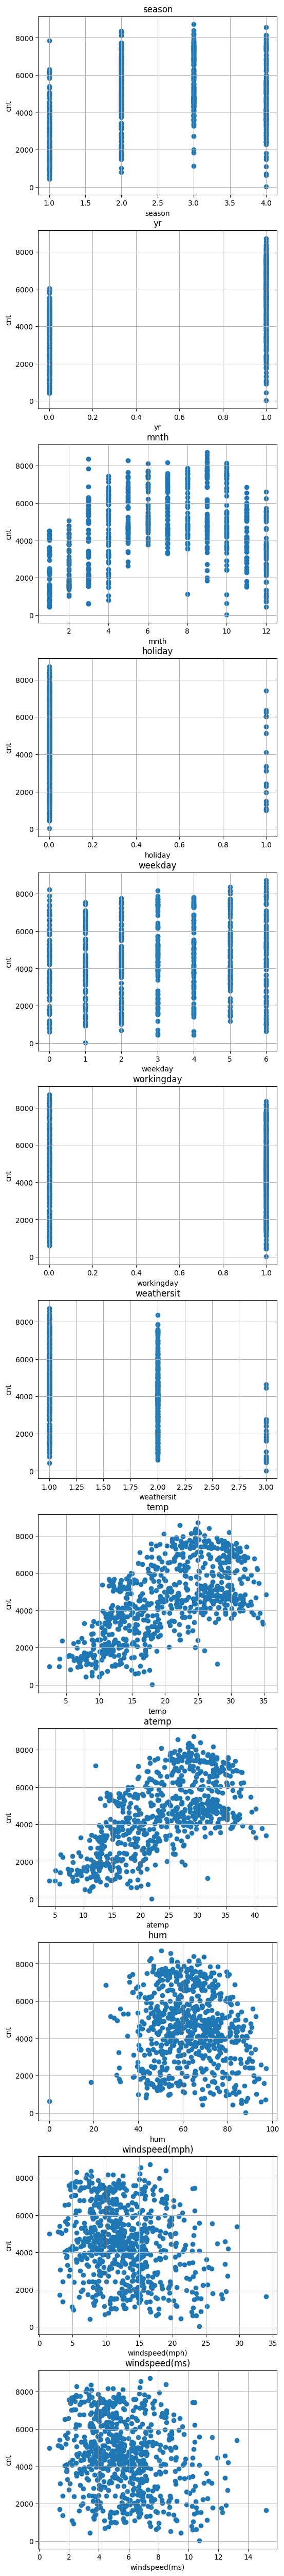

In [3]:
y = np.array(df[["cnt"]])

fig, axs = plt.subplots(df.shape[1]-1, 1, figsize=(6, 64))
for i, col in zip(range(df.shape[1]-1), list(df.columns)):
    axs[i].scatter(np.array(df[[col]]), y)
    axs[i].set_title(col)
    axs[i].set_ylabel("cnt")
    axs[i].set_xlabel(col)
    axs[i].grid()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

__Відповідь:__
1. Залежність "season-cnt" має вигляд синусоїди (y = w0+w1 * sin(w3 * x+w4)
1. Залежність "weathersit-cnt", "workingday-cnt" скоріш за все лінійна. "yr-cnt" на данному етапі також.

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [6]:
ABS_CORR_LIMIT = 0.3

def corr_target(pool_col, target):
    res = {}
    for item in pool_col:
        df_1 = pd.DataFrame(df[[target]].values) 
        df_2 = pd.DataFrame(df[[item]].values)  
        res.update({f"{item}-{target}": df_1.corrwith(df_2)[0]})
    return res

def corr_list(pool_col):
    res = {}
    while len(pool_col) > 1:
        for item in pool_col[1:]:
            df_1 = pd.DataFrame(df[[pool_col[0]]].values) 
            df_2 = pd.DataFrame(df[[item]].values)  
            res.update({f"{pool_col[0]}-{item}": df_1.corrwith(df_2)[0]})
        del pool_col[0]
    return res

def sep_corr(corr_dict, abs_limit=ABS_CORR_LIMIT):
    res = {}
    for item in corr_dict:
        if abs(corr_dict.get(item)) > ABS_CORR_LIMIT:
            res.update({item: corr_dict.get(item)})
    return res


# High level correlation > 0.5, Midlle level correlation > 0.3

pool_col = list(df.columns)
target = pool_col.pop()

corr_target_dict = corr_target(pool_col, target)
corr_dict = corr_list(pool_col)

res_target = sep_corr(corr_target_dict)
res_corr = sep_corr(corr_dict)

In [48]:
print("Кореляція між предметними ознаками та цільовим значенням 'cnt':")
[print(f"{item}: {corr_target_dict.get(item)}") for item in corr_target_dict]
print(f"\nКоефіціент кореляції більше 0.3 означає середній ступінь кореляції, а більше 0.5 - високий.")

Кореляція між предметними ознаками та цільовим значенням 'cnt':
season-cnt: 0.4061003707986359
yr-cnt: 0.5667097078680867
mnth-cnt: 0.27997711221927124
holiday-cnt: -0.06834771589248419
weekday-cnt: 0.06744341241063048
workingday-cnt: 0.06115606306052079
weathersit-cnt: -0.2973912388346634
temp-cnt: 0.627494009033492
atemp-cnt: 0.6310656998491813
hum-cnt: -0.10065856213715522
windspeed(mph)-cnt: -0.23454499742167004
windspeed(ms)-cnt: -0.23454499742168927

Коефіціент кореляції більше 0.3 означає середній ступень кореляції, а більше 0.5 - високий.


In [7]:
print(f"\nКореляція між предметними ознаками та цільовим значенням 'cnt' з коефіціентом кореляції більше {ABS_CORR_LIMIT}:")
[print(f"{item}: {res_target.get(item)}") for item in res_target]
print("\n")



Кореляція між предметними ознаками та цільовим значенням 'cnt' з коефіціентом кореляції більше 0.3:
season-cnt: 0.4061003707986359
yr-cnt: 0.5667097078680867
temp-cnt: 0.627494009033492
atemp-cnt: 0.6310656998491813




В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [8]:
print("Кореляція між предметними ознаками за виключенням 'cnt':")
[print(f"{item}: {corr_dict.get(item)}") for item in corr_dict]
print(f"\nКоефіціент кореляції більше 0.3 означає середній ступінь кореляції, а більше 0.5 - високий.")

Кореляція між предметними ознаками за виключенням 'cnt':
season-yr: -0.0018443425624092766
season-mnth: 0.8314401142104259
season-holiday: -0.010536658735999254
season-weekday: -0.0030798813391720073
season-workingday: 0.012484963237440519
season-weathersit: 0.019211028056670527
season-temp: 0.3343148563990946
season-atemp: 0.34287561270753286
season-hum: 0.2054447645397407
season-windspeed(mph): -0.2290463373468449
season-windspeed(ms): -0.22904633734689697
yr-mnth: -0.001792433841195875
yr-holiday: 0.007954310803060178
yr-weekday: -0.005460765185946702
yr-workingday: -0.002012621193520849
yr-weathersit: -0.048726541200201076
yr-temp: 0.04760357191602301
yr-atemp: 0.04610614853842198
yr-hum: -0.11065104471777937
yr-windspeed(mph): -0.011817059907781412
yr-windspeed(ms): -0.01181705990765556
mnth-holiday: 0.01919089525339544
mnth-weekday: 0.009509312860350066
mnth-workingday: -0.0059009512701980625
mnth-weathersit: 0.04352809839245879
mnth-temp: 0.22020533515337312
mnth-atemp: 0.227458

In [9]:
print(f"\nКореляція між предметними ознаками за виключенням 'cnt' з коефіціентом кореляції більше {ABS_CORR_LIMIT}:")
[print(f"{item}: {res_corr.get(item)}") for item in res_corr]
print("\n")



Кореляція між предметними ознаками за виключенням 'cnt' з коефіціентом кореляції більше 0.3:
season-mnth: 0.8314401142104259
season-temp: 0.3343148563990946
season-atemp: 0.34287561270753286
weathersit-hum: 0.5910445992972725
temp-atemp: 0.9917015532294639
windspeed(mph)-windspeed(ms): 1.0




## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [10]:
df[[ "temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [11]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [12]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [13]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [14]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [15]:
regressor = LinearRegression()
regressor.fit(X, y)
for col, w in zip(df_shuffled.columns, regressor.coef_):
    print(f"{col}: {w}")

season: 570.8638501320808
yr: 1021.968374035042
mnth: -141.30042714888475
holiday: -86.7589678764022
weekday: 137.2260243674752
workingday: 56.39207450989123
weathersit: -330.22859154239825
temp: 367.45187644001305
atemp: 585.5777455406493
hum: -145.61314651687744
windspeed(mph): 12456475364833.373
windspeed(ms): -12456475365031.836


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [16]:
from sklearn.linear_model import Lasso

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
for col, w in zip(df_shuffled.columns, lasso_regressor.coef_):
    print(f"{col}: {w}")

season: 560.2416160308862
yr: 1019.4634940657196
mnth: -128.7306270367869
holiday: -86.15278133371095
weekday: 137.3478939049631
workingday: 55.21237064135677
weathersit: -332.3698569623486
temp: 376.36323620969597
atemp: 576.5307935045538
hum: -144.129155003486
windspeed(mph): -197.13968940248404
windspeed(ms): -2.8051512738133662e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [17]:
from sklearn.linear_model import Ridge

ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
for col, w in zip(df_shuffled.columns, ridge_regressor.coef_):
    print(f"{col}: {w}")

season: 563.0645722520193
yr: 1018.9483787875306
mnth: -131.8733202824786
holiday: -86.74609799709202
weekday: 138.00511117871915
workingday: 55.903110375064806
weathersit: -332.3497884990724
temp: 386.4578891919171
atemp: 566.3470470600581
hum: -145.07132729867268
windspeed(mph): -99.25944108181756
windspeed(ms): -99.25944115431525


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [18]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)
    
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)
    
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проанализируйте динамику весов при увеличении параметра регуляризации:

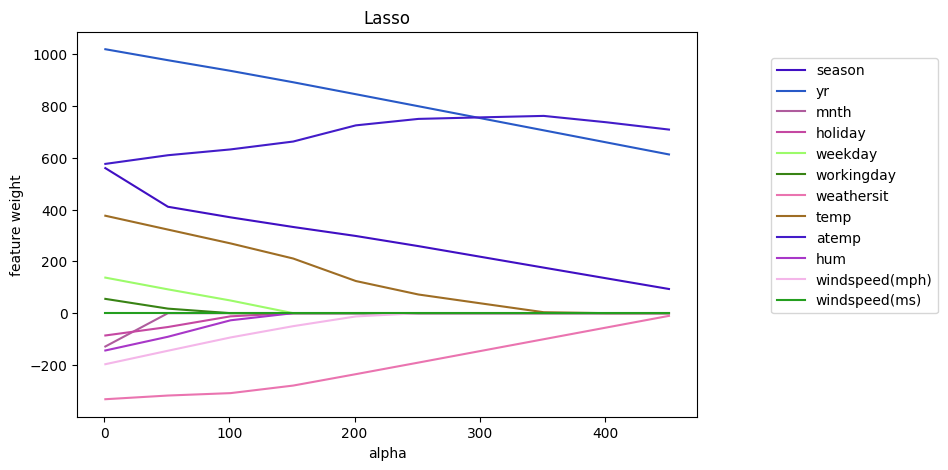

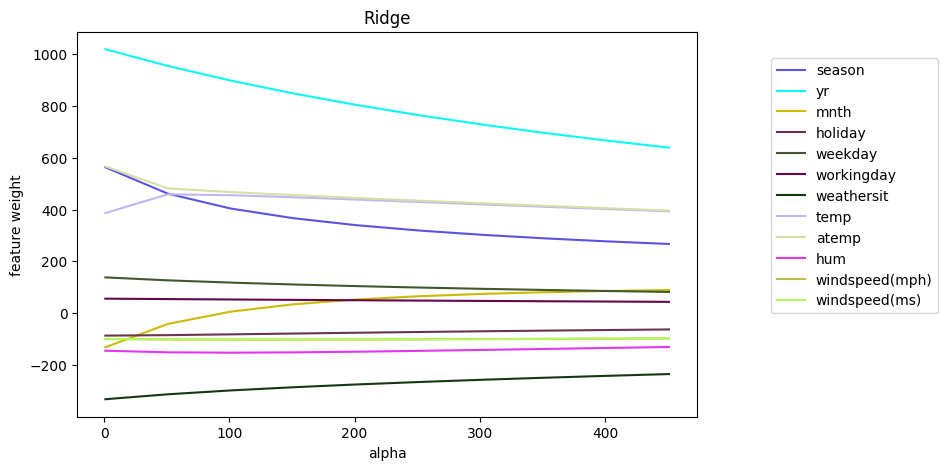

In [19]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

__Відповідь:__
1. Регуляризатор Lasso агрессивніше зменьшує ваги при одну і тому ж alpha.
1. Якщо alpha в регуляризаторі Lasso буде дуже великим всі ваги обнуляться. При збільшенні alpha зануляются все більше і більше коефіціентів.
1. Так. Регуляризатор Lasso зануляє "windspeed(ms)" при alpha > 0. Це видно з графіку. Ridge не зануляє.
1. Lasso більш підходящий бо зменьшує швидше ваги і зануляє меньш важливі при збільшенні alpha.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [20]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Alpha = 6
season: 532.0189828413536
yr: 1015.0602226430597
mnth: -100.03952614356652
holiday: -83.2939598752991
weekday: 132.50446549095793
workingday: 51.557085614074055
weathersit: -330.5598567399815
temp: 370.67985503003166
atemp: 581.3969310655002
hum: -140.00740550068855
windspeed(mph): -191.7714084713498
windspeed(ms): -2.6855326892515688e-08


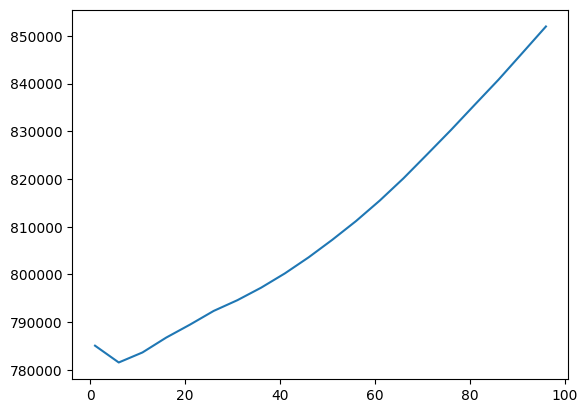

In [21]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor_lcv = LassoCV(alphas=alphas, cv=3)
regressor_lcv.fit(X, y)
mse = [mse_row.mean() for mse_row in regressor_lcv.mse_path_]
mse = np.array(mse)

plt.plot(regressor_lcv.alphas_, mse)

print(f"Alpha = {regressor_lcv.alpha_}")
for col, w in zip(df_shuffled.columns, regressor_lcv.coef_):
    print(f"{col}: {w}")
    
# data = np.stack([regressor_lcv.alphas_, mse], 1)
# create_plot(data, "Alpha - mean MSE", "alpha", "MSE", (8, 5))
# Помилка - RuntimeError: matplotlib does not support generators as input

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


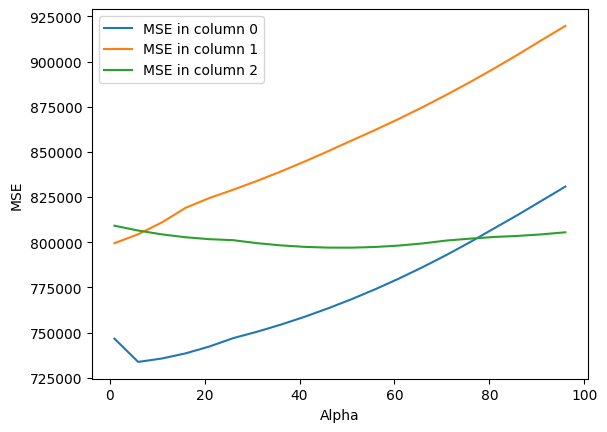

In [22]:
# fig, axs = plt.subplots(regressor_lcv.mse_path_.shape[1], 1, figsize=(8, 16))
# for i in range(regressor_lcv.mse_path_.shape[1]):
#     axs[i].plot(regressor_lcv.alphas_, regressor_lcv.mse_path_[:, i],)
#     axs[i].set_title(f"MSE in column {i}")
#     axs[i].set_ylabel("MSE")
#     axs[i].set_xlabel("Alpha")
#     axs[i].grid()

# В одном масштабі наглядніше ніж на окремих графіках
for i in range(regressor_lcv.mse_path_.shape[1]):
    plt.plot(regressor_lcv.alphas_, regressor_lcv.mse_path_[:, i], label=f"MSE in column {i}")
    plt.ylabel("MSE")
    plt.xlabel("Alpha")
    plt.legend()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

Найбільші ваги:
1. yr: 1015.0602226430597 - лише 2 роки тому не зовсім видно кореляцію.
1. atemp: 581.3969310655002 - залежність є, але при дуже високих температурах більше 28 падає.
1. season: 532.0189828413536 - залежність має вигляд синусоїди як і mnth, тому не дуже корелює, але мала кількість варіантів дає стійку залежніть. Останній стовбець має велику похибку.  
1. temp: 370.67985503003166 -  залежність є, але при дуже високих температурах більше 25 падає.

Найбільші значення аренди припадають на літо-осінь коли температура більше 20 і бізнес розвивається, тому логічно що вони мають великі коефіціенти.


#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

Найменші ваги:
1. weathersit: -330.5598567399815 - чим більші опади тим меньше орендують, не всім подобається кататися по дощу.
1. windspeed(mph): -191.7714084713498 - чим більший вітер тим меньше орендують, бо важче кататися.
1. hum: -140.00740550068855 - при опадах збільшується вологість і є сильна кореляція weathersit-hum: 0.591.

Залежності логічні але дуже велике розсіювання що не дає їм називатися повністю лінійими.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

1. windspeed(ms): -2.6855326892515688e-08 - приймаємо рівним нулю бо меньше 1e-3.

windspeed(ms) та windspeed(mph) дублюють один одного і ми його виключили з моделі, тому що досить одного windspeed(mph) для знаходження залежності.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.